# ASMSA: Train AAE model with the tuned hyperparameters

**Previous steps**
- [prepare.ipynb](prepare.ipynb): Download and sanity check input files
- [tune.ipynb](tune.ipynb): Perform initial hyperparameter tuning for this molecule

**Next step**
- [md.ipynb](md.ipynb): Use a trained model in MD simulation with Gromacs

## Notebook setup

In [1]:
threads = 2
import os
os.environ['OMP_NUM_THREADS']=str(threads)
import tensorflow as tf

# PyTorch favours OMP_NUM_THREADS in environment
import torch

# Tensorflow needs explicit cofig calls
tf.config.threading.set_inter_op_parallelism_threads(threads)
tf.config.threading.set_intra_op_parallelism_threads(threads)

2024-10-17 11:24:30.200572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 11:24:30.219865: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 11:24:30.223832: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 11:24:30.283935: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 11:24:31.702576: W tensorflow/compiler/tf2

In [2]:
from asmsa.tuning_analyzer import TuningAnalyzer
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import urllib.request
from tensorflow import keras
import keras_tuner
import asmsa.visualizer as visualizer
import asmsa

2024-10-17 11:24:35.222055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6597 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:61:00.0, compute capability: 8.0


## Input files

All input files are prepared (up- or downloaded) in [prepare.ipynb](prepare.ipynb). 


In [3]:
exec(open('inputs.py').read())


## Apply the tuning results

In [4]:
# pick from plots in tune.ipynb

best_enc_seed=32 # 128
best_disc_seed=32

In [5]:
# Get best HP from latest tuning
analyzer = TuningAnalyzer()
analyzer.get_best_hp(num_trials=3)

Analyzing tuning from: /home/jovyan/ASMSA/analysis/10142024-115724/
Printing results of tuning: /home/jovyan/ASMSA/analysis/10142024-115724/
-----(1)-----
Trial ID: d749678d8a3985db3e51c20867d1390f3623ec4328a701421b171fc0f3b40982
Hyperparameters:
activation: gelu
ae_number_of_layers: 2
disc_number_of_layers: 5
batch_size: 64
optimizer: Adam
learning_rate: 0.0002
ae_loss_fn: MeanSquaredError
disc_loss_fn: BinaryCrossentropy
Score: 0.1535467840592782
-----(2)-----
Trial ID: 3c27b3d275872d253f42d243e94532ef14986f4643cfbb16c5484ee9709c2e09
Hyperparameters:
activation: relu
ae_number_of_layers: 2
disc_number_of_layers: 5
batch_size: 128
optimizer: Adam
learning_rate: 0.0002
ae_loss_fn: MeanSquaredError
disc_loss_fn: BinaryCrossentropy
Score: 0.1544874129651062
-----(3)-----
Trial ID: b05c6c6345362ad81874e5f8a55f5a65d4d31a9a91c1785d32eff1980b1460b6
Hyperparameters:
activation: relu
ae_number_of_layers: 2
disc_number_of_layers: 5
batch_size: 64
optimizer: Adam
learning_rate: 0.0002
ae_loss_fn

In [6]:
# Select HP to use by specifying trial_id
#  e.g: trial_id = '483883b929b3445bff6dee9759c4d50ee3a4ba7f0db22e665c49b5f942d9693b'
# ... or don't specify, by default use the trial with the lowest score
trial_id = ''

hps = None
for trial in analyzer.sorted_trials:
    if trial['trial_id'] == trial_id:
        hps = trial['hp']
    
if not hps:
    print(f'Could not find trial with specified ID, using one with the lowest score - {analyzer.sorted_trials[0]["trial_id"]}')
    hps = analyzer.sorted_trials[0]['hp']
    
print(hps)

Could not find trial with specified ID, using one with the lowest score - d749678d8a3985db3e51c20867d1390f3623ec4328a701421b171fc0f3b40982
{'activation': 'gelu', 'ae_number_of_layers': 2, 'disc_number_of_layers': 5, 'batch_size': 64, 'optimizer': 'Adam', 'learning_rate': 0.0002, 'ae_loss_fn': 'MeanSquaredError', 'disc_loss_fn': 'BinaryCrossentropy'}


## Load datasets
Load filtered trajectory datasets that were processed in **prepare.ipynb**. Trajectories are in internal coordinates format.

In [7]:
# load train dataset
X_train = tf.data.Dataset.load('datasets/intcoords/train')

# get batched version of dataset to feed to AAE model for training
X_train_batched = X_train.batch(hps['batch_size'],drop_remainder=True)

# get numpy version for visualization purposes
X_train_np = np.stack(list(X_train))
X_train_np.shape

2024-10-17 11:24:39.890119: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(31288, 1355)

In [8]:
# load test dataset
X_test = tf.data.Dataset.load('datasets/intcoords/test')

# get batched version of dataset to feed to AAE model for prediction
X_test_batched = X_test.batch(hps['batch_size'],drop_remainder=True)

# get numpy version for testing purposes
X_test_np = np.stack(list(X_test))
X_test_np.shape

2024-10-17 11:24:40.929291: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(6697, 1355)

In [9]:
# Merge (zip) the trajectory density of the training set points
# those will be aligned with the probability density of the prior distribution 

dens = tf.data.Dataset.from_tensor_slices(np.loadtxt('datasets/train_density.txt'))
X_train_dens = tf.data.Dataset.zip((X_train,dens)).batch(hps['batch_size'],drop_remainder=True)

In [10]:
for e in X_train_dens.as_numpy_iterator():
    break
e[0].shape,e[1].shape

((64, 1355), (64,))

## Train

### Distribution prior
Train with common prior distributions. See https://www.tensorflow.org/probability/api_docs/python/tfp/distributions for all available distributions. It is ideal to use tuned Hyperparameters for training.

In [11]:
# set used prior

# this one is (more or less) required to with the density alignment
prior = tfp.distributions.MultivariateNormalDiag(loc=[0.,0.])

#prior = tfp.distributions.Normal(loc=0, scale=1)
# prior = tfp.distributions.Uniform()
# prior = tfp.distributions.Weibull(1,0.5)
# prior = tfp.distributions.Cauchy(loc=0, scale=1)

In [12]:
#gm = asmsa.GaussianMixture([[-1,-1],[.8,1],[1,-.8]],[[1,1],[.5,.5],[.5,.5]],[.6,.25,.15])
#gm = asmsa.GaussianMixture([[-1,-1],[1,1]],[[.2,.2],[.5,.5]],[.6,.4])
gm = asmsa.GaussianMixture([[-1,-1],[1,1]],[[.4,.4],[.7,.7]],[.6,.4])
s = gm.sample((2048,))
p=gm.prob(s)

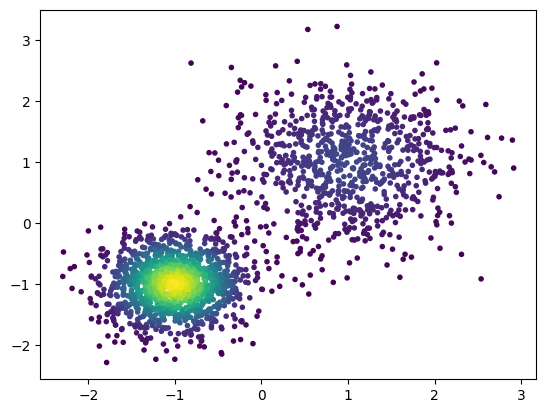

In [13]:
import matplotlib.pyplot as plt
plt.scatter(s[:,0],s[:,1],c=p,marker='.')
plt.colorbar
plt.show()

In [33]:
# prepare model using the best hyperparameters
testm = asmsa.AAEModel((X_train_np.shape[1],),
                       prior=prior, # gm, #prior,
                       hp=hps,
                       enc_seed=best_enc_seed,
                       disc_seed=best_disc_seed,
                       with_density=True
                      )
# make plain AE
# testm.disc = None

testm.compile()

In [34]:
# specify earlystopping callback to avoid overfitting
monitored_metric = "AE loss min"

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor=monitored_metric,
    min_delta=0.0001,
    patience=50, #15,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

Epoch 1/600
488/488 - 23s - 47ms/step - AE loss max: 0.9915 - AE loss min: 0.9915 - cheat loss max: -4.1111e-02 - cheat loss min: -4.1111e-02 - density loss: 0.0780 - disc loss max: 0.1766 - disc loss min: 0.1766
Epoch 2/600
488/488 - 4s - 8ms/step - AE loss max: 0.9882 - AE loss min: 0.9882 - cheat loss max: 0.0249 - cheat loss min: 0.0249 - density loss: 0.0600 - disc loss max: -9.4968e-02 - disc loss min: -9.4968e-02
Epoch 3/600
488/488 - 4s - 8ms/step - AE loss max: 0.9852 - AE loss min: 0.9852 - cheat loss max: -1.1763e-02 - cheat loss min: -1.1763e-02 - density loss: 0.0726 - disc loss max: -3.4014e-02 - disc loss min: -3.4014e-02
Epoch 4/600
488/488 - 4s - 8ms/step - AE loss max: 0.9833 - AE loss min: 0.9833 - cheat loss max: -2.2316e-01 - cheat loss min: -2.2316e-01 - density loss: 0.1871 - disc loss max: 0.1775 - disc loss min: 0.1775
Epoch 5/600
488/488 - 3s - 6ms/step - AE loss max: 0.9807 - AE loss min: 0.9807 - cheat loss max: 0.0566 - cheat loss min: 0.0566 - density loss

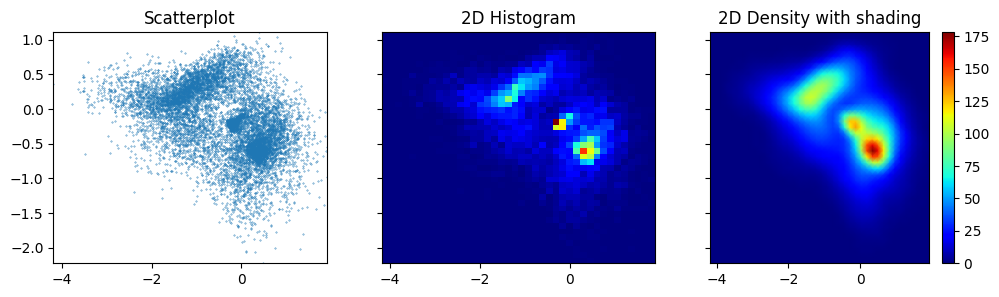

488/488 - 5s - 11ms/step - AE loss max: 0.9756 - AE loss min: 0.9756 - cheat loss max: 0.2339 - cheat loss min: 0.2339 - density loss: 0.0770 - disc loss max: 0.0295 - disc loss min: 0.0295
Epoch 26/600
488/488 - 4s - 9ms/step - AE loss max: 0.9803 - AE loss min: 0.9803 - cheat loss max: 0.1522 - cheat loss min: 0.1522 - density loss: 0.1000 - disc loss max: 0.0165 - disc loss min: 0.0165
Epoch 27/600
488/488 - 4s - 8ms/step - AE loss max: 0.9749 - AE loss min: 0.9749 - cheat loss max: 0.1416 - cheat loss min: 0.1416 - density loss: 0.1094 - disc loss max: 0.0481 - disc loss min: 0.0481
Epoch 28/600
488/488 - 3s - 6ms/step - AE loss max: 0.9773 - AE loss min: 0.9773 - cheat loss max: 0.2841 - cheat loss min: 0.2841 - density loss: 0.0956 - disc loss max: 0.0257 - disc loss min: 0.0257
Epoch 29/600
488/488 - 4s - 9ms/step - AE loss max: 0.9747 - AE loss min: 0.9747 - cheat loss max: 0.1246 - cheat loss min: 0.1246 - density loss: 0.0867 - disc loss max: -2.4761e-02 - disc loss min: -2.4

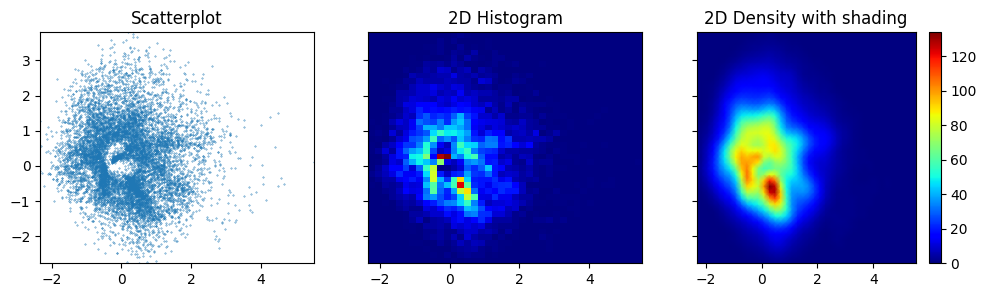

488/488 - 4s - 7ms/step - AE loss max: 0.9655 - AE loss min: 0.9655 - cheat loss max: 0.2193 - cheat loss min: 0.2193 - density loss: 0.0934 - disc loss max: -5.5533e-02 - disc loss min: -5.5533e-02
Epoch 51/600
488/488 - 2s - 5ms/step - AE loss max: 0.9672 - AE loss min: 0.9672 - cheat loss max: 0.1217 - cheat loss min: 0.1217 - density loss: 0.1106 - disc loss max: 0.0138 - disc loss min: 0.0138
Epoch 52/600
488/488 - 2s - 4ms/step - AE loss max: 0.9675 - AE loss min: 0.9675 - cheat loss max: 0.1148 - cheat loss min: 0.1148 - density loss: 0.1310 - disc loss max: 0.0398 - disc loss min: 0.0398
Epoch 53/600
488/488 - 2s - 5ms/step - AE loss max: 0.9659 - AE loss min: 0.9659 - cheat loss max: 0.2126 - cheat loss min: 0.2126 - density loss: 0.1056 - disc loss max: 6.4588e-04 - disc loss min: 6.4588e-04
Epoch 54/600
488/488 - 2s - 5ms/step - AE loss max: 0.9658 - AE loss min: 0.9658 - cheat loss max: 0.0970 - cheat loss min: 0.0970 - density loss: 0.0889 - disc loss max: 0.0101 - disc lo

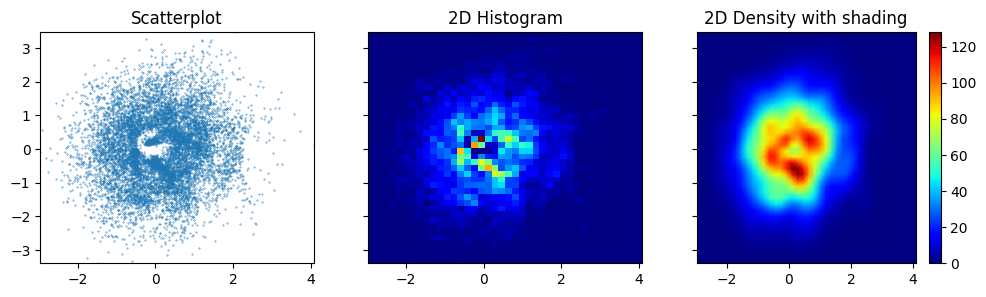

488/488 - 4s - 9ms/step - AE loss max: 0.9617 - AE loss min: 0.9617 - cheat loss max: 0.1606 - cheat loss min: 0.1606 - density loss: 0.0990 - disc loss max: -7.1372e-03 - disc loss min: -7.1372e-03
Epoch 76/600
488/488 - 3s - 5ms/step - AE loss max: 0.9614 - AE loss min: 0.9614 - cheat loss max: 0.1876 - cheat loss min: 0.1876 - density loss: 0.0972 - disc loss max: 0.0201 - disc loss min: 0.0201
Epoch 77/600
488/488 - 2s - 4ms/step - AE loss max: 0.9613 - AE loss min: 0.9613 - cheat loss max: 0.1769 - cheat loss min: 0.1769 - density loss: 0.1087 - disc loss max: -1.7693e-02 - disc loss min: -1.7693e-02
Epoch 78/600
488/488 - 4s - 8ms/step - AE loss max: 0.9615 - AE loss min: 0.9615 - cheat loss max: 0.1780 - cheat loss min: 0.1780 - density loss: 0.1250 - disc loss max: 0.0380 - disc loss min: 0.0380
Epoch 79/600
488/488 - 4s - 9ms/step - AE loss max: 0.9619 - AE loss min: 0.9619 - cheat loss max: 0.1650 - cheat loss min: 0.1650 - density loss: 0.1234 - disc loss max: 0.0199 - disc 

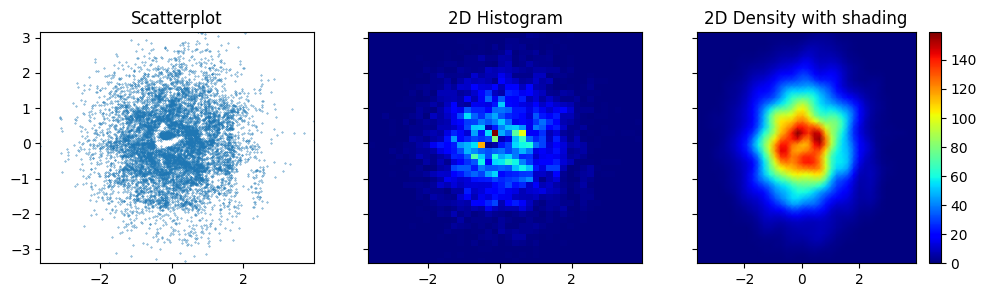

488/488 - 5s - 10ms/step - AE loss max: 0.9605 - AE loss min: 0.9605 - cheat loss max: 0.2478 - cheat loss min: 0.2478 - density loss: 0.0922 - disc loss max: -8.1804e-03 - disc loss min: -8.1804e-03
Epoch 101/600
488/488 - 3s - 5ms/step - AE loss max: 0.9607 - AE loss min: 0.9607 - cheat loss max: 0.2610 - cheat loss min: 0.2610 - density loss: 0.1017 - disc loss max: -1.7153e-03 - disc loss min: -1.7153e-03
Epoch 102/600
488/488 - 3s - 5ms/step - AE loss max: 0.9603 - AE loss min: 0.9603 - cheat loss max: 0.2435 - cheat loss min: 0.2435 - density loss: 0.0995 - disc loss max: -2.3269e-02 - disc loss min: -2.3269e-02
Epoch 103/600
488/488 - 3s - 5ms/step - AE loss max: 0.9601 - AE loss min: 0.9601 - cheat loss max: 0.2340 - cheat loss min: 0.2340 - density loss: 0.1035 - disc loss max: 0.0196 - disc loss min: 0.0196
Epoch 104/600
488/488 - 3s - 6ms/step - AE loss max: 0.9606 - AE loss min: 0.9606 - cheat loss max: 0.2483 - cheat loss min: 0.2483 - density loss: 0.0946 - disc loss max:

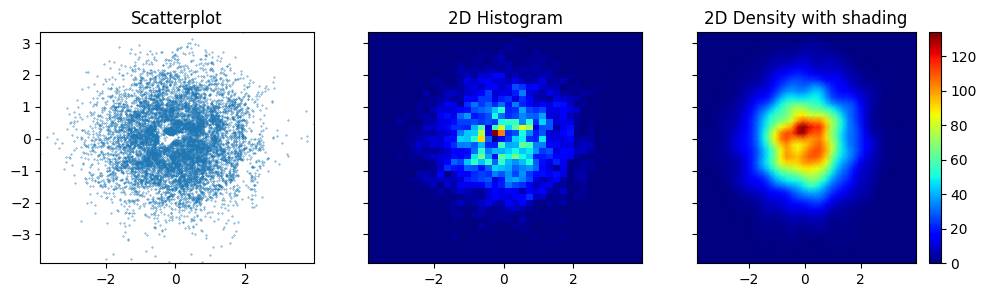

488/488 - 3s - 6ms/step - AE loss max: 0.9590 - AE loss min: 0.9590 - cheat loss max: 0.2744 - cheat loss min: 0.2744 - density loss: 0.1042 - disc loss max: -8.0682e-03 - disc loss min: -8.0682e-03
Epoch 126/600
488/488 - 3s - 5ms/step - AE loss max: 0.9590 - AE loss min: 0.9590 - cheat loss max: 0.2339 - cheat loss min: 0.2339 - density loss: 0.1105 - disc loss max: 0.0028 - disc loss min: 0.0028
Epoch 127/600
488/488 - 3s - 6ms/step - AE loss max: 0.9595 - AE loss min: 0.9595 - cheat loss max: 0.2167 - cheat loss min: 0.2167 - density loss: 0.1079 - disc loss max: 0.0149 - disc loss min: 0.0149
Epoch 128/600
488/488 - 2s - 5ms/step - AE loss max: 0.9594 - AE loss min: 0.9594 - cheat loss max: 0.2022 - cheat loss min: 0.2022 - density loss: 0.1074 - disc loss max: 0.0204 - disc loss min: 0.0204
Epoch 129/600
488/488 - 3s - 6ms/step - AE loss max: 0.9593 - AE loss min: 0.9593 - cheat loss max: 0.2035 - cheat loss min: 0.2035 - density loss: 0.1003 - disc loss max: -3.3764e-02 - disc l

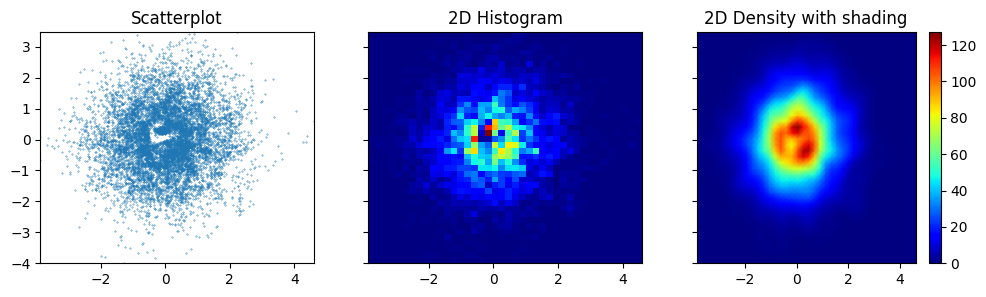

488/488 - 3s - 7ms/step - AE loss max: 0.9592 - AE loss min: 0.9592 - cheat loss max: 0.2073 - cheat loss min: 0.2073 - density loss: 0.1133 - disc loss max: -9.0503e-03 - disc loss min: -9.0503e-03
Epoch 151/600
488/488 - 2s - 4ms/step - AE loss max: 0.9590 - AE loss min: 0.9590 - cheat loss max: 0.1918 - cheat loss min: 0.1918 - density loss: 0.1035 - disc loss max: -3.9012e-02 - disc loss min: -3.9012e-02
Epoch 152/600
488/488 - 2s - 4ms/step - AE loss max: 0.9589 - AE loss min: 0.9589 - cheat loss max: 0.1578 - cheat loss min: 0.1578 - density loss: 0.0954 - disc loss max: 0.0033 - disc loss min: 0.0033
Epoch 153/600
488/488 - 3s - 7ms/step - AE loss max: 0.9593 - AE loss min: 0.9593 - cheat loss max: 0.1923 - cheat loss min: 0.1923 - density loss: 0.0895 - disc loss max: -1.4608e-02 - disc loss min: -1.4608e-02
Epoch 154/600
488/488 - 2s - 4ms/step - AE loss max: 0.9589 - AE loss min: 0.9589 - cheat loss max: 0.1972 - cheat loss min: 0.1972 - density loss: 0.0929 - disc loss max: 

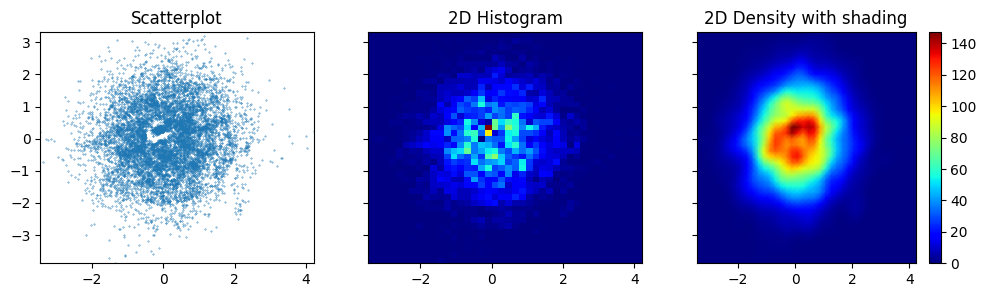

488/488 - 3s - 7ms/step - AE loss max: 0.9587 - AE loss min: 0.9587 - cheat loss max: 0.1352 - cheat loss min: 0.1352 - density loss: 0.1040 - disc loss max: -5.0319e-03 - disc loss min: -5.0319e-03
Epoch 176/600
488/488 - 2s - 4ms/step - AE loss max: 0.9586 - AE loss min: 0.9586 - cheat loss max: 0.1119 - cheat loss min: 0.1119 - density loss: 0.0965 - disc loss max: 0.0080 - disc loss min: 0.0080
Epoch 177/600
488/488 - 2s - 4ms/step - AE loss max: 0.9585 - AE loss min: 0.9585 - cheat loss max: 0.1275 - cheat loss min: 0.1275 - density loss: 0.0957 - disc loss max: -4.4083e-02 - disc loss min: -4.4083e-02
Epoch 178/600
488/488 - 3s - 6ms/step - AE loss max: 0.9584 - AE loss min: 0.9584 - cheat loss max: 0.1593 - cheat loss min: 0.1593 - density loss: 0.0956 - disc loss max: 8.7902e-04 - disc loss min: 8.7902e-04
Epoch 179/600
488/488 - 2s - 4ms/step - AE loss max: 0.9581 - AE loss min: 0.9581 - cheat loss max: 0.1725 - cheat loss min: 0.1725 - density loss: 0.1015 - disc loss max: -2

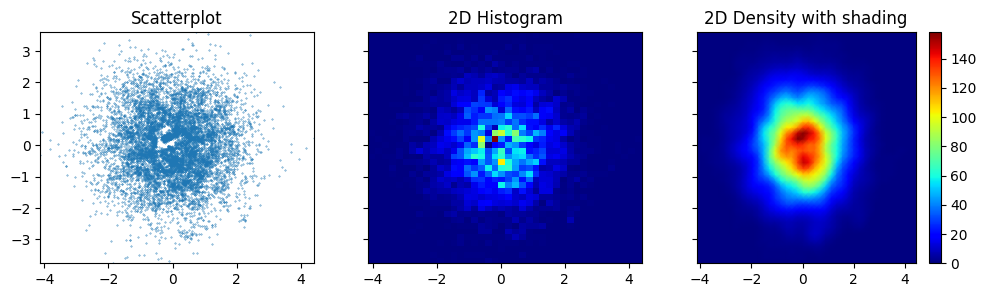

488/488 - 4s - 8ms/step - AE loss max: 0.9571 - AE loss min: 0.9571 - cheat loss max: 0.0772 - cheat loss min: 0.0772 - density loss: 0.1120 - disc loss max: -6.3682e-03 - disc loss min: -6.3682e-03
Epoch 201/600
488/488 - 3s - 5ms/step - AE loss max: 0.9573 - AE loss min: 0.9573 - cheat loss max: 0.0940 - cheat loss min: 0.0940 - density loss: 0.1143 - disc loss max: -1.5944e-02 - disc loss min: -1.5944e-02
Epoch 202/600
488/488 - 2s - 4ms/step - AE loss max: 0.9576 - AE loss min: 0.9576 - cheat loss max: 0.1043 - cheat loss min: 0.1043 - density loss: 0.1076 - disc loss max: 0.0141 - disc loss min: 0.0141
Epoch 203/600
488/488 - 3s - 5ms/step - AE loss max: 0.9573 - AE loss min: 0.9573 - cheat loss max: 0.1203 - cheat loss min: 0.1203 - density loss: 0.1109 - disc loss max: 0.0081 - disc loss min: 0.0081
Epoch 204/600
488/488 - 2s - 5ms/step - AE loss max: 0.9571 - AE loss min: 0.9571 - cheat loss max: 0.1258 - cheat loss min: 0.1258 - density loss: 0.1091 - disc loss max: 0.0101 - d

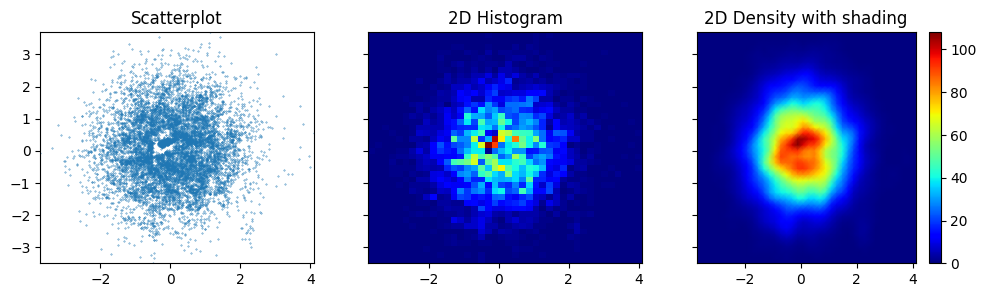

488/488 - 3s - 6ms/step - AE loss max: 0.9569 - AE loss min: 0.9569 - cheat loss max: 0.1222 - cheat loss min: 0.1222 - density loss: 0.1007 - disc loss max: -1.2437e-02 - disc loss min: -1.2437e-02
Epoch 226/600
488/488 - 3s - 5ms/step - AE loss max: 0.9568 - AE loss min: 0.9568 - cheat loss max: 0.1265 - cheat loss min: 0.1265 - density loss: 0.1030 - disc loss max: -5.6405e-02 - disc loss min: -5.6405e-02
Epoch 227/600
488/488 - 3s - 6ms/step - AE loss max: 0.9571 - AE loss min: 0.9571 - cheat loss max: 0.1326 - cheat loss min: 0.1326 - density loss: 0.1046 - disc loss max: -1.9709e-02 - disc loss min: -1.9709e-02
Epoch 228/600
488/488 - 3s - 5ms/step - AE loss max: 0.9566 - AE loss min: 0.9566 - cheat loss max: 0.1228 - cheat loss min: 0.1228 - density loss: 0.1127 - disc loss max: -1.9039e-02 - disc loss min: -1.9039e-02
Epoch 229/600
488/488 - 2s - 5ms/step - AE loss max: 0.9566 - AE loss min: 0.9566 - cheat loss max: 0.1594 - cheat loss min: 0.1594 - density loss: 0.1061 - disc 

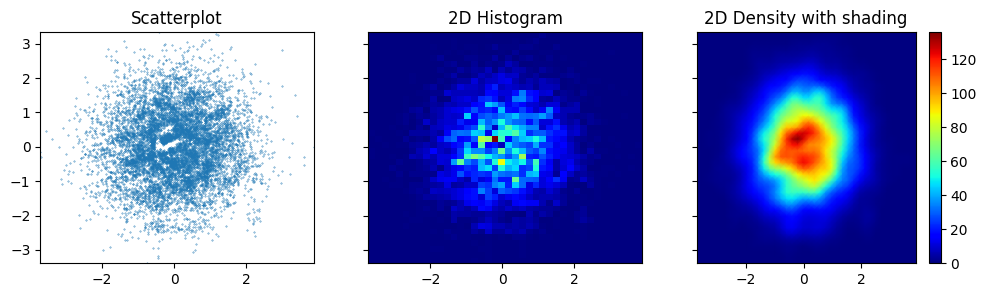

488/488 - 3s - 6ms/step - AE loss max: 0.9565 - AE loss min: 0.9565 - cheat loss max: 0.1461 - cheat loss min: 0.1461 - density loss: 0.0987 - disc loss max: 0.0256 - disc loss min: 0.0256
Epoch 251/600
488/488 - 3s - 5ms/step - AE loss max: 0.9566 - AE loss min: 0.9566 - cheat loss max: 0.1370 - cheat loss min: 0.1370 - density loss: 0.1007 - disc loss max: -1.2211e-02 - disc loss min: -1.2211e-02
Epoch 252/600
488/488 - 3s - 7ms/step - AE loss max: 0.9566 - AE loss min: 0.9566 - cheat loss max: 0.1670 - cheat loss min: 0.1670 - density loss: 0.1002 - disc loss max: 0.0074 - disc loss min: 0.0074
Epoch 253/600
488/488 - 3s - 5ms/step - AE loss max: 0.9565 - AE loss min: 0.9565 - cheat loss max: 0.1806 - cheat loss min: 0.1806 - density loss: 0.1051 - disc loss max: -5.5141e-03 - disc loss min: -5.5141e-03
Epoch 254/600
488/488 - 3s - 6ms/step - AE loss max: 0.9565 - AE loss min: 0.9565 - cheat loss max: 0.1778 - cheat loss min: 0.1778 - density loss: 0.1028 - disc loss max: -3.4109e-0

KeyboardInterrupt: 

In [35]:
# train it (can be repeated several times to add more epochs)

testm.fit(X_train_dens, # X_train_batched,
          epochs=600,
          verbose=2, # this flag is essential due to connection with EarlyStopping callback (epoch vs batch)
          callbacks=[
              early_stop_cb,
              visualizer.VisualizeCallback(testm,freq=25,inputs=X_train_np[15000:25000],figsize=(12,3))
          ])

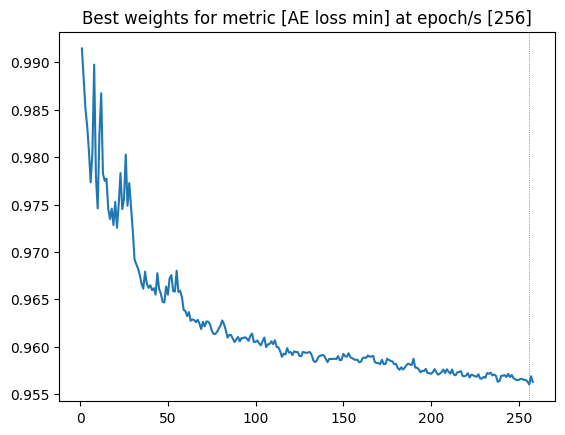

In [36]:
# - plot AE loss min during training
# - specify "since_epoch" for better plot scaling (ignore outliers)
# - note that numbering of epochs starts at 1, 0th epoch does not exist
since_epoch = 1

assert since_epoch > 0
history = np.array(testm.history.history[monitored_metric])
y = history[since_epoch-1:]
x = list(range(since_epoch, len(y)+since_epoch))
result = np.array(list(map(lambda x: x+1, np.where(history == history.min())[0]))) # add +1 to convert index to epoch

[plt.axvline(_x, linewidth=0.5, color='r', ls=':') for _x in result]
plt.plot(x, y)
plt.title(f'Best weights for metric [{monitored_metric}] at epoch/s {result}')
plt.show()

In [37]:
# whatever test
''' 
batch_size = 256

val_result = testm.predict(X_test_batched)
mse = keras.losses.MeanSquaredError()
dataset_size = X_test_np.shape[0]
print(dataset_size)
mse_result=[]
for i in range(0, dataset_size, batch_size):
    if i+batch_size > dataset_size:
        batch_size = batch_size-(i+batch_size-dataset_size)
    batch_mse = mse(X_test_np[i:i+batch_size],val_result[i:i+batch_size]).numpy()
    mse_result.append(batch_mse)

mse_result'''

' \nbatch_size = 256\n\nval_result = testm.predict(X_test_batched)\nmse = keras.losses.MeanSquaredError()\ndataset_size = X_test_np.shape[0]\nprint(dataset_size)\nmse_result=[]\nfor i in range(0, dataset_size, batch_size):\n    if i+batch_size > dataset_size:\n        batch_size = batch_size-(i+batch_size-dataset_size)\n    batch_mse = mse(X_test_np[i:i+batch_size],val_result[i:i+batch_size]).numpy()\n    mse_result.append(batch_mse)\n\nmse_result'

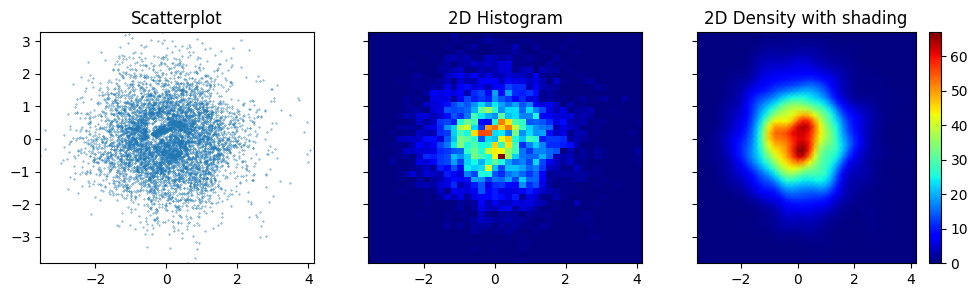

In [38]:
# final visualization, pick a slice of the input data for demo purposes
#visualizer.Visualizer(figsize=(12,3)).make_visualization(testm.call_enc(X_train_np[15000:20000]).numpy())

# on test data
visualizer.Visualizer(figsize=(12,3)).make_visualization(testm.call_enc(X_test_np).numpy())

In [39]:
# load testing trajectory for further visualizations and computations
tr = md.load('x_test.xtc',top=conf)
idx=tr[0].top.select("name CA")

# for trivial cases like Ala-Ala, where superposing on CAs fails
#idx=tr[0].top.select("element != H") 

tr.superpose(tr[0],atom_indices=idx)

# reshuffle the geometry to get frame last so that we can use vectorized calculations
geom = np.moveaxis(tr.xyz ,0,-1)
geom.shape

(144, 3, 6697)

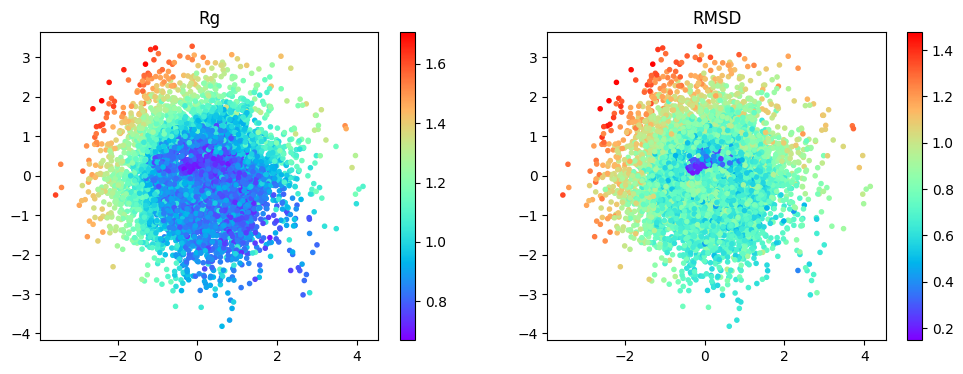

In [40]:
# Rgyr and rmsd color coded in low dim (rough view)

lows = testm.call_enc(X_test_np).numpy()
rg = md.compute_rg(tr)
base = md.load(conf)
rmsd = md.rmsd(tr,base[0])
cmap = plt.get_cmap('rainbow')
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rg,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("Rg")
plt.subplot(122)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rmsd,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("RMSD")
plt.show()

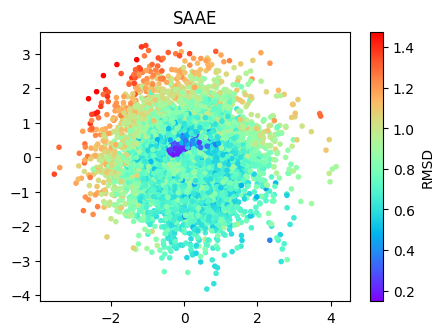

In [51]:
stride=1
plt.figure(figsize=(5,3.5))
plt.scatter(lows[::stride,0],lows[::stride,1],marker='.',c=rmsd[::stride],cmap=cmap)
plt.colorbar(cmap=cmap).set_label('RMSD')
plt.title("SAAE")
plt.savefig('fig.pdf')
plt.show()

In [42]:
s = prior.sample((2048,))
gen = testm.dec.predict(s)[:,0,:]

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 


In [43]:
np.savetxt('sample_int.txt',gen)

In [44]:
np.savetxt('sample_latent.txt',s.numpy())

In [ ]:
# not used
'''testm.enc.save('enc.keras')
testm.dec.save('dec.keras')
testm.disc.save('dec.keras')'''

In [ ]:
gm2 = asmsa.GaussianMixture([[-1,-1],[.8,1],[1,-.8]],[[1,1],[.5,.5],[.5,.5]],[.8,.1,.1])
s = gm2.sample((20480,))
p=gm2.prob(s)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(s[:,0],s[:,1],c=p,marker='.')
plt.colorbar
plt.show()

In [ ]:
# prepare model using the best hyperparameters
testm2 = asmsa.AAEModel((X_train_np.shape[1],),
                       prior=gm2, #prior,
                       hp=hps,
                       enc_seed=best_enc_seed,
                       disc_seed=best_disc_seed,
                       with_density=True
                      )
testm2.compile()

In [ ]:
# train it (can be repeated several times to add more epochs)

testm2.fit(X_train_dens, # X_train_batched,
          epochs=600,
          verbose=2, # this flag is essential due to connection with EarlyStopping callback (epoch vs batch)
          callbacks=[
              early_stop_cb,
              visualizer.VisualizeCallback(testm,freq=25,inputs=X_train_np[15000:25000],figsize=(12,3))
          ])

In [ ]:
# - plot AE loss min during training
# - specify "since_epoch" for better plot scaling (ignore outliers)
# - note that numbering of epochs starts at 1, 0th epoch does not exist
since_epoch = 1

assert since_epoch > 0
history = np.array(testm2.history.history[monitored_metric])
y = history[since_epoch-1:]
x = list(range(since_epoch, len(y)+since_epoch))
result = np.array(list(map(lambda x: x+1, np.where(history == history.min())[0]))) # add +1 to convert index to epoch

[plt.axvline(_x, linewidth=0.5, color='r', ls=':') for _x in result]
plt.plot(x, y)
plt.title(f'Best weights for metric [{monitored_metric}] at epoch/s {result}')
plt.show()

In [ ]:
# final visualization, pick a slice of the input data for demo purposes
#visualizer.Visualizer(figsize=(12,3)).make_visualization(testm.call_enc(X_train_np[15000:20000]).numpy())

# on test data
visualizer.Visualizer(figsize=(12,3)).make_visualization(testm.call_enc(X_test_np).numpy())

In [ ]:
# Rgyr and rmsd color coded in low dim (rough view)

lows = testm2.call_enc(X_test_np).numpy()
rg = md.compute_rg(tr)
base = md.load(conf)
rmsd = md.rmsd(tr,base[0])
cmap = plt.get_cmap('rainbow')
plt.figure(figsize=(32,12))
plt.subplot(121)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rg,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("Rg")
plt.subplot(122)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rmsd,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("RMSD")
plt.show()

### Image prior

**Almost surely broken now with the density alignment**

Use Image as a prior distribution. Again use tuned Hyperparameters for better training performance.

In [ ]:
urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1I2WP92MMWS5s5vin_4cvmruuV-1W77Hl", "mushroom_bw.png")

In [ ]:
mmush = asmsa.AAEModel((X_train_np.shape[1],),
                       hp=hps,
                       enc_seed=best_enc_seed,
                       disc_seed=best_disc_seed,
                       prior='mushroom_bw.png'
                      )
mmush.compile()

In [ ]:
mmush.fit(X_train_batched,
          epochs=500,
          verbose=2,
          callbacks=[
              early_stop_cb,
              visualizer.VisualizeCallback(mmush,freq=25,inputs=X_train_np[15000:25000],figsize=(12,3))
          ])

In [ ]:
# - plot AE loss min during training
# - specify "since_epoch" for better plot scaling (ignore outliers)
# - note that numbering of epochs starts at 1, 0th epoch does not exist
since_epoch = 1
monitored_metric = 'AE loss min'

assert since_epoch > 0
history = np.array(mmush.history.history[monitored_metric])
y = history[since_epoch-1:]
x = list(range(since_epoch, len(y)+since_epoch))
result = np.array(list(map(lambda x: x+1, np.where(history == history.min())[0]))) # add +1 to convert index to epoch

[plt.axvline(_x, linewidth=0.5, color='r', ls=':') for _x in result]
plt.plot(x, y)
plt.title(f'Best weights for metric [{monitored_metric}] at epoch/s {result}')
plt.show()

In [ ]:
batch_size = 256

val_result = testm.predict(X_test_batched)
mse = keras.losses.MeanSquaredError()
dataset_size = X_test_np.shape[0]
print(dataset_size)
mse_result=[]
for i in range(0, dataset_size, batch_size):
    if i+batch_size > dataset_size:
        batch_size = batch_size-(i+batch_size-dataset_size)
    batch_mse = mse(X_test_np[i:i+batch_size],val_result[i:i+batch_size]).numpy()
    mse_result.append(batch_mse)

mse_result

In [ ]:
step=4
tr2 = tr[::step]
lows = mmush.call_enc(X_test_np[::step]).numpy()
rg = md.compute_rg(tr2)
base = md.load(conf)
rmsd = md.rmsd(tr2,base[0])
cmap = plt.get_cmap('rainbow')
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rg,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("Rg")
plt.subplot(122)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rmsd,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("RMSD")
plt.show()

## Save the model for Gromacs

*Another wave of magics ...*

There are multiple ways how atoms are numbered in PDB, GRO, etc. files. 

So far we worked with atoms numbered as in the `conf` PDB file, assuming `traj` XTC file was consistent with those.
If the topology was used, it might have had different numbering, as Gromacs likes. 

In the subsequent simulations, we assume the usual protocol starting with `pdb2gmx` to generate topology,
hence Gromacsish atom numbering will be followed afterwards.
Therefore we need `plumed.dat` to pick the atoms according to the PDB file order, and skip hydrogens added by Gromacs. 

Many things can go wrong, therefore we strongly encorage to check the results manually. For example, the first residuum (ASP) of tryptophan cage may look like the following in PDB file:

    ATOM      1  N   ASP     1      28.538  39.747  31.722  1.00  1.00           N
    ATOM      2  CA  ASP     1      28.463  39.427  33.168  1.00  1.00           C
    ATOM      3  C   ASP     1      29.059  37.987  33.422  1.00  1.00           C
    ATOM      4  O   ASP     1      30.226  37.748  33.735  1.00  1.00           O
    ATOM      5  CB  ASP     1      26.995  39.482  33.630  1.00  1.00           C
    ATOM      6  CG  ASP     1      26.889  39.307  35.101  1.00  1.00           C
    ATOM      7  OD1 ASP     1      27.749  39.962  35.773  1.00  1.00           O
    ATOM      8  OD2 ASP     1      26.012  38.510  35.611  1.00  1.00           O
    
Which turns Gromacs topology: 

     1         N3      1    ASP      N      1     0.0782      14.01   ; qtot 0.0782
     2          H      1    ASP     H1      2       0.22      1.008   ; qtot 0.2982
     3          H      1    ASP     H2      3       0.22      1.008   ; qtot 0.5182
     4          H      1    ASP     H3      4       0.22      1.008   ; qtot 0.7382
     5         CT      1    ASP     CA      5     0.0292      12.01   ; qtot 0.7674
     6         HP      1    ASP     HA      6     0.1141      1.008   ; qtot 0.8815
     7         CT      1    ASP     CB      7    -0.0235      12.01   ; qtot 0.858
     8         HC      1    ASP    HB1      8    -0.0169      1.008   ; qtot 0.8411
     9         HC      1    ASP    HB2      9    -0.0169      1.008   ; qtot 0.8242
    10          C      1    ASP     CG     10     0.8194      12.01   ; qtot 1.644
    11         O2      1    ASP    OD1     11    -0.8084         16   ; qtot 0.8352
    12         O2      1    ASP    OD2     12    -0.8084         16   ; qtot 0.0268
    13          C      1    ASP      C     13     0.5621      12.01   ; qtot 0.5889
    14          O      1    ASP      O     14    -0.5889         16   ; qtot 0
    
Besides adding hydrogens, the carboxyl group of the protein backbone (atoms 3,4 in PDB) is pushed down (to become 13,14 in the topology).

Consequently, the ATOMS setting in the generated `plumed.dat` must be:

    model: PYTORCH_MODEL_CV FILE=model.pt ATOMS=1,5,13,14,7,10,11,12, ...
    
i.e., the atoms are enumerated *in the order* of PDB file but *referring to numbers* of topology file. 

If there is any mismatch, the MD simulations are likely to fail, or at least to produce meaningless results.

It's also **critical** that `{conf}`, `{top}`, and `{gro}` correspond to one another, and that `{gro}` **includes hydrogens**.


In [ ]:
import tf2onnx
import onnx2torch
import tempfile

def _convert_to_onnx(model, destination_path):
#    model = keras.models.load_model(source_path)

    input_tensor = model.layers[0]._input_tensor
#    input_tensor = model.inputs[0]
    input_signature = tf.TensorSpec(
        name=input_tensor.name, shape=input_tensor.shape, dtype=input_tensor.dtype
    )
    output_name = model.layers[-1].name

    @tf.function(input_signature=[input_signature])
    def _wrapped_model(input_data):
        return {output_name: model(input_data)}

    tf2onnx.convert.from_function(
        _wrapped_model, input_signature=[input_signature], output_path=destination_path
    )

In [ ]:
model = testm

with tempfile.NamedTemporaryFile() as onnx:
#    tf2onnx.convert.from_keras(model.enc,output_path=onnx.name)
    _convert_to_onnx(model.enc,onnx.name)
    torch_encoder = onnx2torch.convert(onnx.name)

# load test geometry dataset
geom = np.stack(list(tf.data.Dataset.load('datasets/geoms/test')))

# XXX: we rely on determinism of the model creation, it must be the same as in prepare.ipynb
# better to store it there in onnx, and reload here

sparse_dists = asmsa.NBDistancesSparse(geom.shape[0], density=nb_density)
mol = asmsa.Molecule(pdb=conf,top=topol,ndx=index,fms=[sparse_dists])
    
mol_model = mol.get_model()

train_mean = np.loadtxt('datasets/intcoords/mean.txt',dtype=np.float32)
train_scale = np.loadtxt('datasets/intcoords/scale.txt',dtype=np.float32)

def complete_model(x):
    return torch_encoder(
        ((mol_model(x) - torch.from_numpy(np.reshape(train_mean,(-1,1)))) / torch.from_numpy(np.reshape(train_scale,(-1,1)))).reshape(-1)
    )

# Save Torch model using TorchScript trace
example_input = torch.randn([geom.shape[0], geom.shape[1], 1])
traced_script_module = torch.jit.trace(complete_model, example_input)

model_file_name = "model.pt"
traced_script_module.save(model_file_name)

In [ ]:
# validate

example_geom = np.random.rand(geom.shape[0], geom.shape[1], 1)
#X = mol.intcoord(example_geom).T
X = ((mol.intcoord(example_geom) - np.reshape(train_mean,(-1,1))) / np.reshape(train_scale,(-1,1))).T
tf_low = np.array(model.enc(X))

torch_geom = torch.tensor(example_geom.reshape(-1), dtype=torch.float32, requires_grad=True)
torch_low = traced_script_module(torch_geom)

for out in torch_low:
    grad = torch.autograd.grad(out, torch_geom, retain_graph=True)

    
# should be very small, eg. less than 1e-5
np.max(np.abs(tf_low - torch_low.detach().numpy()))

In [ ]:
# Atom numbering magic with Gromacs, see above

grotr = md.load(gro)
nhs = grotr.topology.select('element != H')

with open(index) as f:
    f.readline()
    ndx = np.fromstring(" ".join(f),dtype=np.int32,sep=' ')-1

pdb2gmx = nhs[np.argsort(ndx)]+1

# maybe double check manually wrt. the files
# pdb2gmx

In [ ]:
ndx

#### Determine range of CVs for simulation

Plumed maintains a grid to approximate accumulated bias potential, which size must be known in advance.

Making it wider is safe, the simulation is less likely to escape and crash, but there is perfomance penalty.

Calculate the CVs on the testset, determine their range, and add some margins


In [ ]:
grid_margin = 1.  # that many times the actual computed size added on both sides

lows = model.call_enc(X_test_np).numpy()
lmin = np.min(lows,axis=0)
lmax = np.max(lows,axis=0)
llen = lmax-lmin
lmin -= llen * grid_margin
lmax += llen * grid_margin

In [ ]:
with open("plumed.dat","w") as p:
    p.write(f"""\
RESTART
WHOLEMOLECULES ENTITY0=1-{grotr.xyz.shape[1]}
model: PYTORCH_MODEL_CV FILE={model_file_name} ATOMS={','.join(map(str,pdb2gmx))}
metad: METAD ARG=model.node-0,model.node-1 PACE=1000 HEIGHT=1 BIASFACTOR=15 SIGMA=0.1,0.1 GRID_MIN={lmin[0]},{lmin[1]} GRID_MAX={lmax[0]},{lmax[1]} FILE=HILLS
PRINT FILE=COLVAR ARG=model.node-0,model.node-1,metad.bias STRIDE=100
""")

In [ ]:
# XXX: these were some tests for the density alingment, I'm not sure anymore; not important either

In [ ]:
traj = 'validate.xtc'
tr = md.load(traj,top=conf)
train_mean = np.loadtxt('datasets/intcoords/mean.txt',dtype=np.float32)
train_scale = np.loadtxt('datasets/intcoords/scale.txt',dtype=np.float32)

In [ ]:
geom = np.moveaxis(tr.xyz,0,-1)
geom.shape

In [ ]:
density = 2
sparse_dists = asmsa.NBDistancesSparse(geom.shape[0], density=density)
mol = asmsa.Molecule(pdb=conf,top=topol,ndx=index,fms=[sparse_dists])


In [ ]:
intcoord = mol.intcoord(geom).T
intcoord -= train_mean
intcoord /= train_scale

In [ ]:
import gromacs.fileformats as gf

In [ ]:
rms = gf.XPM('rmsd.xpm')

In [ ]:
plt.hist(rms.array.flatten(),bins=50)
plt.show()

In [ ]:
rms_sort = np.sort(rms.array.astype(np.float32))
erms = np.exp(-rms_sort[:,:50])

In [ ]:
dens = (np.sum(erms,axis=1)-1.) / (erms.shape[1] - 1)

In [ ]:
plt.hist(dens,bins=20)
plt.show()

In [ ]:
lows = testm.enc(intcoord)

In [ ]:
lows.shape, dens.shape

In [ ]:
plt.scatter(lows[:,0],lows[:,1],c=dens,marker='.',cmap='rainbow')
plt.colorbar()
plt.show()